In [1]:
import numpy as np
import scipy.optimize as so
import scipy.sparse as sp
import pandas as pd
import awesomeplot.core as plt
%matplotlib notebook

In [2]:
# at each node I have the variables P, Q, Vm, Va
# generators: PVm equality constraint
# loads: PQ equality constraint
# slack (generator): VmVa equality constraint
# additional inequality constraints for bounds on free variables ...

# looking for optimal dispatch, we probably have to release eq. constraints on P at PV nodes 

# two balance equations per node, i.e. real and reactive power
# typical initial conditions Vm=1pu, Va=0

# TODO: is Kron reduction an issue?
# TODO: PTDF ?

In [3]:
# use for doc strings
so.fmin_slsqp?

In [4]:
%%latex 
\begin{align}
0 &= P_i - \sum\limits_j |V_i||V_j| (G_{ij}\cos{(\theta_i - \theta_j)} + B_{ij}\sin{(\theta_i - \theta_j)}) \\
0 &= Q_i - \sum\limits_j |V_i||V_j| (G_{ij}\sin{(\theta_i - \theta_j)} - B_{ij}\cos{(\theta_i - \theta_j)})
\end{align}

<IPython.core.display.Latex object>

In [5]:
def signs(arr):
    signs = np.ones(n)
    signs[arr == "PQ"] = -1.
    return signs 
       

In [65]:
def update_df(df, x, mapping):
    df = df.stack()
    for node in range(n):
        if df[node]["type"]  == "PV":
            df[node][[0, 1, 2]] = x[mapping["nodes"][node]]
        elif df[node]["type"]  == "PQ":
            df[node][[2, 3]] = x[mapping["nodes"][node]]
        elif df[node]["type"]  == "sl":
            df[node][[0, 1]] = x[mapping["nodes"][node]]
    return df.unstack()

def setup_system_and_bounds(df):
    
    df = df.stack()
    
    m = 2 * sum(df.loc[:, "type"] == "sl") + 2 * sum(df.loc[:, "type"] == "PQ") + 3 * sum(df.loc[:, "type"] == "PV")
    mapping = {"P":[], "Q":[], "Va":[], "Vm":[], "nodes":{}} # index of independent variables
    bounds = []
    
    assert sorted(df.index.levels[1]) == ['P', 'Q', 'Va', 'Vm', 'type']
    
    for node in range(n):
        if df[node]["type"]  == "PV":
            df[node]["Vm"] = 1.
            
            mapping["nodes"][node] = range(len(bounds), len(bounds) + 3)
            
            mapping["P"].append(len(bounds))
            bounds.append([0.5, 1.5]) # P
            mapping["Q"].append(len(bounds))
            bounds.append([0.1, 0.3]) # Q
            mapping["Va"].append(len(bounds))
            bounds.append([0.9, 1.1]) # Va
            
        elif df[node]["type"]  == "PQ":
            df[node]["P"] = -1.
            df[node]["Q"] = -.1
            
            mapping["nodes"][node] = range(len(bounds), len(bounds) + 2)
            
            mapping["Va"].append(len(bounds))
            bounds.append([-np.pi/2., np.pi/2.]) # Va
            mapping["Vm"].append(len(bounds))
            bounds.append([0.9, 1.1]) #Vm
            
        elif df[node]["type"]  == "sl":
            df[node]["Vm"] = 1.
            df[node]["Va"] = 0.
            
            mapping["nodes"][node] = range(len(bounds), len(bounds) + 2)
            
            mapping["P"].append(len(bounds))
            bounds.append([0.5, 1.5]) # P
            mapping["Q"].append(len(bounds))
            bounds.append([0.1, 0.3]) # Q
            
        else:
            raise ValueError("weird error")

    return df.unstack(), mapping, bounds
    

In [9]:
class prices(object):
    p = 1 
    q = 0.5 
    pass 

def objective_function(x, prices, mapping):
    return np.sum(prices.p * np.abs(x[mapping["P"]])) + np.sum(prices.q * np.abs(x[mapping["Q"]]))


In [10]:
def equality_constraints(x, adm, df, mapping):
    df = update_df(df, x, mapping)
    v = df.Vm.astype(np.float64).values * np.exp(1.j * df.Va.astype(np.float64).values)
    coupling = v * adm.dot(v).conjugate()
    dP = df.P.astype(np.float64).values - np.real(coupling)
    dQ = df.Q.astype(np.float64).values - np.imag(coupling) 
    return np.concatenate([dP, dQ])
            
# type constraints
#    b[2::4][types == "sl"] = np.array([- eps, eps]) + 1. # p.u.
#    b[3::4][types == "sl"] = np.array([- eps, eps]) + 0. # rad
#    b[0::4][types == "PQ"] = np.array([- eps, eps]) - 1. # p.u.
#    b[1::4][types == "PQ"] = np.array([- eps, eps]) - 1. # p.u.
#    b[0::4][types == "PV"] = np.array([- eps, eps]) + 1 # p.u.
#    b[2::4][types == "PV"] = np.array([- eps, eps]) + 1 # p.u.

In [97]:
# define state vector x = (P, Q, Va) / (P, Vm, Va) / (P, Q, Vm) with independent state variables at each node
n = 100

types = np.repeat("PQ", n)
# add some generators
types[::2] = "PV"
# choose a slack bus
types[0] = "sl"

df = pd.DataFrame(data={"type":types,
                     "P":np.zeros(n, dtype=np.float64),
                     "Q":np.zeros(n, dtype=np.float64), 
                     "Vm":np.zeros(n, dtype=np.float64), 
                     "Va":np.zeros(n, dtype=np.float64)
                    })

adm = np.zeros([n, n], dtype=np.complex128)
for i in xrange(n):
    adm[i, (i+1)%n] = adm[(i+1)%n, i] = .1 + 1.j
adm[3, 7] = adm[7, 3] = .1 + 1.j
adm = sp.csr_matrix(adm)

In [98]:
df, mapping, bounds = setup_system_and_bounds(df)
x = np.mean(bounds, axis=1)

In [92]:
print objective_function(x, prices, mapping)
print equality_constraints(x, adm, df, mapping)

11.0
[ 0.8        -0.31255925 -0.79100243  0.47488151 -0.79100243  0.57488151
 -0.79100243  0.47488151 -0.79100243  0.57488151 -0.79100243  0.57488151
 -0.79100243  0.57488151 -0.79100243  0.57488151 -0.79100243  0.57488151
 -0.79100243 -0.31255925  2.2         1.5244494   1.11231041  2.14889881
  1.11231041  1.14889881  1.11231041  2.14889881  1.11231041  1.14889881
  1.11231041  1.14889881  1.11231041  1.14889881  1.11231041  1.14889881
  1.11231041  1.14889881  1.11231041  1.5244494 ]


In [99]:
sol = so.minimize(objective_function, x, args=(prices, mapping,), method="SLSQP", bounds=bounds, 
                  constraints={"type": "eq", "fun":equality_constraints, "args": (adm, df, mapping,)}, 
                  options={"disp":True}, callback=lambda z: objective_function(z, prices, mapping))
print sol.message
print "Success:", sol.success

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 54.63153884
            Iterations: 29
            Function evaluations: 6305
            Gradient evaluations: 25
Optimization terminated successfully.
Success: True


In [94]:
df = update_df(df, sol.x, mapping)

In [95]:
df

P         Q          Va        Vm type
0    0.99599       0.1           0         1   sl
1         -1      -0.1  -0.0649005       0.9   PQ
2    0.97743  0.218048     1.01246         1   PV
3         -1      -0.1 -0.00499058       0.9   PQ
4   0.959532   0.13923     1.01246         1   PV
5         -1      -0.1   0.0173277  0.918107   PQ
6    1.04246  0.216516     1.09906         1   PV
7         -1      -0.1    0.053763  0.943336   PQ
8     1.0391   0.20897     1.09906         1   PV
9         -1      -0.1   0.0263022   0.91807   PQ
10    0.9896  0.163362     1.03041         1   PV
11        -1      -0.1  -0.0156691  0.917615   PQ
12  0.996148  0.177496     1.01512         1   PV
13        -1      -0.1  -0.0211185  0.917593   PQ
14  0.999727   0.18525     1.01951         1   PV
15        -1      -0.1  -0.0161518  0.917593   PQ
16   1.00408  0.193845     1.02505         1   PV
17        -1      -0.1  -0.0196754  0.917591   PQ
18   0.99913  0.223021     1.01246         1   PV
19        -1      -0.1  -0.0649005       0.9   PQ

<IPython.core.display.Javascript object>


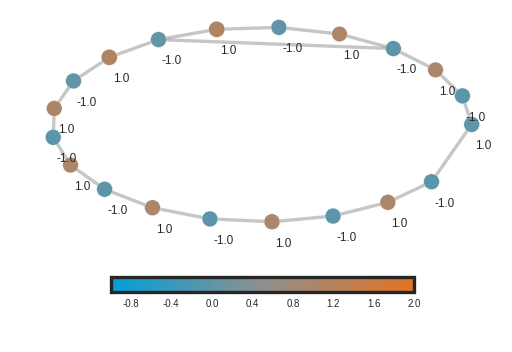

(-1.0910317924347239,
 1.0997677231077487,
 -1.0985376922560537,
 1.0963522161144186)

In [96]:
canvas = plt.Plot()
layout = np.c_[np.cos(np.linspace(0, 1.8 * np.pi, n)), np.sin(np.linspace(0, 1.8 * np.pi, n))]
fig = canvas.add_network(adm.todok(), sym=True, vertex_labels=signs(types),
                   styles={"layout":layout,
                           "vertex_size":200.*np.abs(df.P.astype(np.float64).values),
                           "vertex_color":df.Va.astype(np.float64).values
                          })
fig.axes[0].axis("off")
